In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person399_virus_793.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

(180, 180, 3)


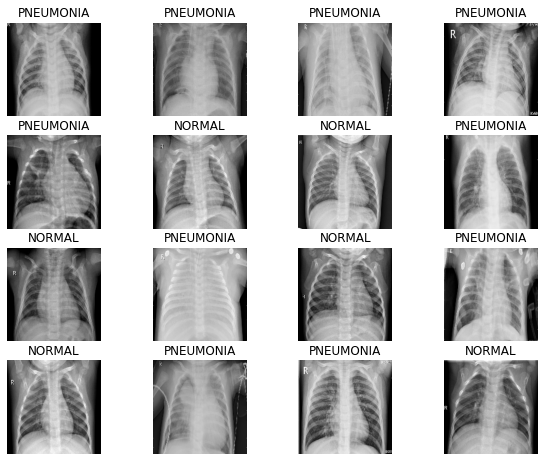

In [14]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
print(image_batch[0].shape)
show_batch(image_batch.numpy(), label_batch.numpy())

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [19]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 99s 238ms/step - loss: 0.5036 - accuracy: 0.7459 - precision: 0.9242 - recall: 0.7160 - val_loss: 0.7368 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 59s 227ms/step - loss: 0.2294 - accuracy: 0.9162 - precision: 0.9747 - recall: 0.9115 - val_loss: 1.2224 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 60s 230ms/step - loss: 0.1843 - accuracy: 0.9301 - precision: 0.9814 - recall: 0.9241 - val_loss: 0.9139 - val_accuracy: 0.7346 - val_precision: 0.7341 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 60s 230ms/step - loss: 0.1966 - accuracy: 0.9292 - precision: 0.9801 - recall: 0.9244 - val_loss: 0.1099 - val_accuracy: 0.9635 - val_precision: 0.9548 - val_recall: 0.9974
Epoch 5/25
261/261 [==============================] - 61s 233ms/step - loss: 0.1836 - accura

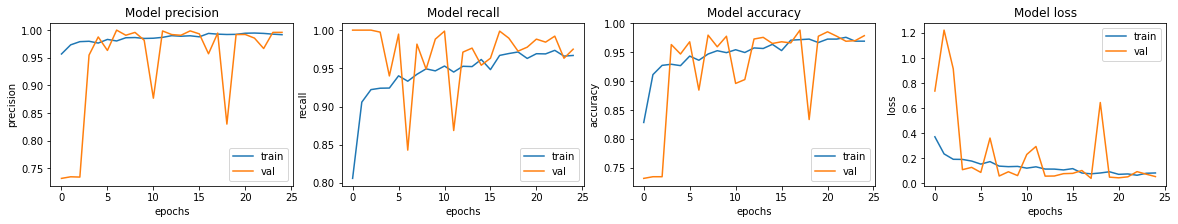

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 145ms/step - loss: 1.1690 - accuracy: 0.7901 - precision: 0.7544 - recall: 0.9846
Loss: 1.1689889430999756,
Accuracy: 0.7900640964508057,
Precision: 0.7544204592704773,
Recall: 0.9846153855323792


In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 20 #16 ->20으로 변경
EPOCHS = 25

In [28]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

In [29]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [30]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [31]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [32]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [33]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

(180, 180, 3)


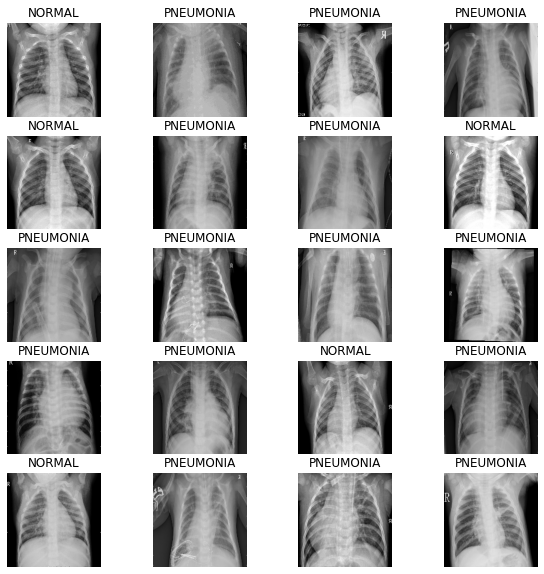

In [34]:
image_batch, label_batch = next(iter(train_ds))
print(image_batch[0].shape)
show_batch(image_batch.numpy(), label_batch.numpy())

심장의 위치로 봤을 때, 좌우반전이 랜덤하게 잘 된것 같습니다.

In [35]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
209/209 [==============================] - 132s 280ms/step - loss: 0.6192 - accuracy: 0.6658 - precision: 0.8887 - recall: 0.6362 - val_loss: 0.6335 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
209/209 [==============================] - 58s 277ms/step - loss: 0.2444 - accuracy: 0.9070 - precision: 0.9739 - recall: 0.8977 - val_loss: 0.9117 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
209/209 [==============================] - 59s 281ms/step - loss: 0.2035 - accuracy: 0.9220 - precision: 0.9748 - recall: 0.9186 - val_loss: 1.1562 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/25
209/209 [==============================] - 60s 287ms/step - loss: 0.1967 - accuracy: 0.9280 - precision: 0.9775 - recall: 0.9261 - val_loss: 0.4328 - val_accuracy: 0.8067 - val_precision: 0.7915 - val_recall: 1.0000
Epoch 5/25
209/209 [==============================] - 61s 293ms/step - loss: 0.1875 - accur

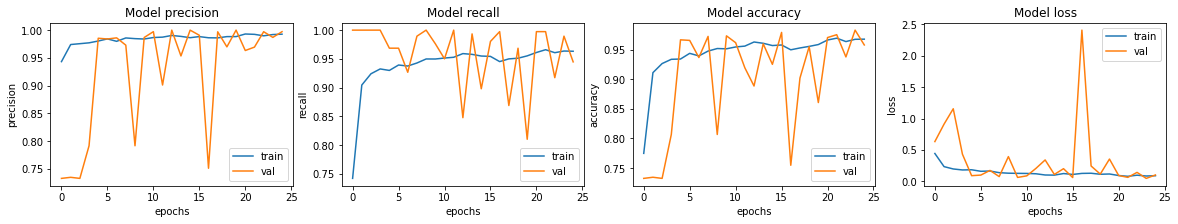

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
  
BATCH_SIZE = 16 #원래대로
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 84s 277ms/step - loss: 0.4979 - accuracy: 0.7354 - precision: 0.9315 - recall: 0.6983 - val_loss: 0.6982 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 72s 276ms/step - loss: 0.2142 - accuracy: 0.9131 - precision: 0.9748 - recall: 0.9058 - val_loss: 1.2119 - val_accuracy: 0.7362 - val_precision: 0.7362 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 72s 276ms/step - loss: 0.1763 - accuracy: 0.9315 - precision: 0.9820 - recall: 0.9251 - val_loss: 0.1265 - val_accuracy: 0.9592 - val_precision: 0.9500 - val_recall: 0.9969
Epoch 4/25
261/261 [==============================] - 72s 278ms/step - loss: 0.1453 - accuracy: 0.9409 - precision: 0.9855 - recall: 0.9344 - val_loss: 0.1741 - val_accuracy: 0.9377 - val_precision: 0.9977 - val_recall: 0.9172
Epoch 5/25
261/261 [==============================] - 73s 280ms/step - loss: 0.1746 - accura

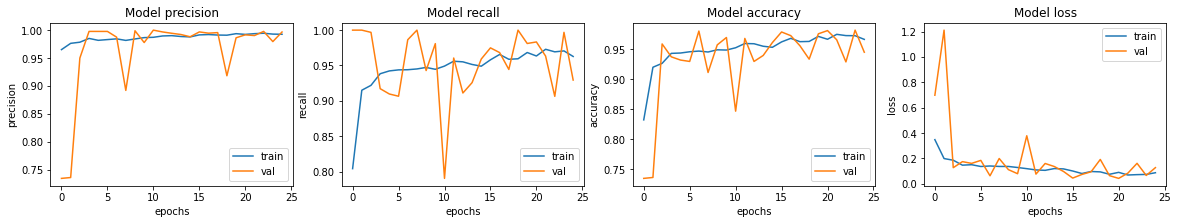

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [39]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

32/32 [==============================] - 43s 1s/step - loss: 0.7828 - accuracy: 0.8413 - precision: 0.8184 - recall: 0.9590
Loss: 0.7828375697135925,
Accuracy: 0.8413461446762085,
Precision: 0.8183807730674744,
Recall: 0.9589743614196777


배치 사이즈 변경으로 큰 차이는 보지 못한 모습입니다  
대신 augmentation의 영향인지 정확도는 크게 늘었습니다.

대조군으로 batch 사이즈 원래대로 해서 해보기, 모델 구조 변경 => batchnomalization 제거해보기, DropOut제거해보기

In [42]:
def conv_block_noBatch(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [43]:
def dense_block_noBatch(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [44]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_noBatch(32),
        conv_block_noBatch(64),
        
        conv_block_noBatch(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block_noBatch(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_noBatch(512, 0.7),
        dense_block_noBatch(128, 0.5),
        dense_block_noBatch(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [45]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
  
BATCH_SIZE = 16 #원래대로
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 83s 276ms/step - loss: 0.6987 - accuracy: 0.5000 - precision: 0.7409 - recall: 0.4974 - val_loss: 0.6990 - val_accuracy: 0.2577 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 71s 272ms/step - loss: 0.6912 - accuracy: 0.4994 - precision: 0.7395 - recall: 0.5111 - val_loss: 0.6942 - val_accuracy: 0.2662 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
261/261 [==============================] - 68s 263ms/step - loss: 0.6964 - accuracy: 0.4162 - precision: 0.7315 - recall: 0.3344 - val_loss: 0.7033 - val_accuracy: 0.2646 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
261/261 [==============================] - 70s 271ms/step - loss: 0.6854 - accuracy: 0.4530 - precision: 0.7359 - recall: 0.4066 - val_loss: 0.6895 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 72s 277ms/step

In [46]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

32/32 [==============================] - 6s 186ms/step - loss: 0.6916 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6916096806526184,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


정확도가 매우 떨어진모습입니다, batchnomalize는 제거하지 않는게 좋을것같습니다.

In [47]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block_noDrop(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        #tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_noDrop(512, 0.7),
        dense_block_noDrop(128, 0.5),
        dense_block_noDrop(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [48]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
  
BATCH_SIZE = 16 #원래대로
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 84s 280ms/step - loss: 0.2869 - accuracy: 0.8811 - precision: 0.9664 - recall: 0.8724 - val_loss: 0.6275 - val_accuracy: 0.7323 - val_precision: 0.7323 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 74s 285ms/step - loss: 0.1504 - accuracy: 0.9449 - precision: 0.9809 - recall: 0.9441 - val_loss: 1.3429 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 73s 280ms/step - loss: 0.1477 - accuracy: 0.9399 - precision: 0.9827 - recall: 0.9358 - val_loss: 0.3544 - val_accuracy: 0.8477 - val_precision: 0.8284 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 74s 282ms/step - loss: 0.1044 - accuracy: 0.9621 - precision: 0.9884 - recall: 0.9603 - val_loss: 0.1727 - val_accuracy: 0.9346 - val_precision: 0.9183 - val_recall: 1.0000
Epoch 6/25
261/261 [==============================] - 76s 293ms/step - loss: 0.1111 - accura

In [49]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

32/32 [==============================] - 6s 174ms/step - loss: 1.5064 - accuracy: 0.7308 - precision: 0.7011 - recall: 0.9923
Loss: 1.506414771080017,
Accuracy: 0.7307692170143127,
Precision: 0.7010869383811951,
Recall: 0.9923076629638672


역시나 정확도가 떨어진 모습입니다, 넣어둔 이유가 있네요

다음은 imbalance 처리를 제외하고 테스트하겠습니다

In [50]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [51]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [52]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [53]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [54]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [55]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [56]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [57]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [58]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
  
BATCH_SIZE = 16 #원래대로
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        #class_weight=class_weight, 가중치 제거
    )

Epoch 1/25
261/261 [==============================] - 71s 231ms/step - loss: 0.2975 - accuracy: 0.8883 - precision: 0.9576 - recall: 0.8857 - val_loss: 0.7899 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 59s 226ms/step - loss: 0.1575 - accuracy: 0.9450 - precision: 0.9662 - recall: 0.9599 - val_loss: 1.2003 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 59s 226ms/step - loss: 0.1170 - accuracy: 0.9607 - precision: 0.9755 - recall: 0.9716 - val_loss: 0.5795 - val_accuracy: 0.7731 - val_precision: 0.7640 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 59s 227ms/step - loss: 0.1029 - accuracy: 0.9642 - precision: 0.9755 - recall: 0.9764 - val_loss: 0.1548 - val_accuracy: 0.9385 - val_precision: 0.9916 - val_recall: 0.9242
Epoch 5/25
261/261 [==============================] - 61s 232ms/step - loss: 0.0882 - accura

In [59]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 148ms/step - loss: 1.4997 - accuracy: 0.7388 - precision: 0.7067 - recall: 0.9949
Loss: 1.4997113943099976,
Accuracy: 0.7387820482254028,
Precision: 0.7067395448684692,
Recall: 0.9948717951774597


결과가 확실히 더 안좋아졌습니다.  
가중치를 주어서 데이터의 imbalance를 보정하는 것이 훨씬 좋은 결과를 얻을 수 있었습니다.

다음은 하이퍼 파라미터를 튜닝하여 85%이상의 정확도를 얻어보겠습니다.

In [97]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 10 #배치사이즈 16 -> 10으로 변경
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [98]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [99]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [100]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [101]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [102]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [103]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [104]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [95]:
print(class_weight)

{0: 1.9519589552238805, 1: 0.6721811757147447}


In [105]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
  
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/25
418/418 [==============================] - 213s 150ms/step - loss: 0.5379 - accuracy: 0.7389 - precision: 0.9178 - recall: 0.7125 - val_loss: 1.0042 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
418/418 [==============================] - 60s 145ms/step - loss: 0.2731 - accuracy: 0.8847 - precision: 0.9705 - recall: 0.8718 - val_loss: 0.1686 - val_accuracy: 0.9337 - val_precision: 0.9233 - val_recall: 0.9921
Epoch 3/25
418/418 [==============================] - 62s 147ms/step - loss: 0.2586 - accuracy: 0.8978 - precision: 0.9706 - recall: 0.8894 - val_loss: 0.4793 - val_accuracy: 0.8038 - val_precision: 1.0000 - val_recall: 0.7326
Epoch 4/25
418/418 [==============================] - 61s 146ms/step - loss: 0.2234 - accuracy: 0.9049 - precision: 0.9752 - recall: 0.8942 - val_loss: 0.1069 - val_accuracy: 0.9615 - val_precision: 0.9788 - val_recall: 0.9685
Epoch 5/25
418/418 [==============================] - 63s 151ms/step - loss: 0.2139 - accur

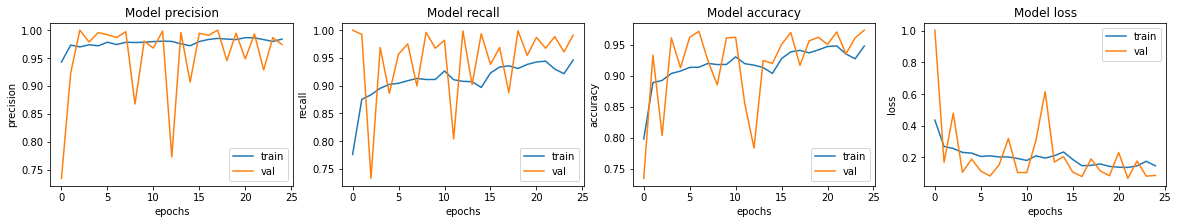

In [106]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [107]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 6s 92ms/step - loss: 1.0707 - accuracy: 0.7420 - precision: 0.7101 - recall: 0.9923
Loss: 1.0707437992095947,
Accuracy: 0.7419871687889099,
Precision: 0.710091769695282,
Recall: 0.9923076629638672


In [108]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 10
EPOCHS = 10

In [109]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

In [110]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [111]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [112]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [113]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [114]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

(180, 180, 3)


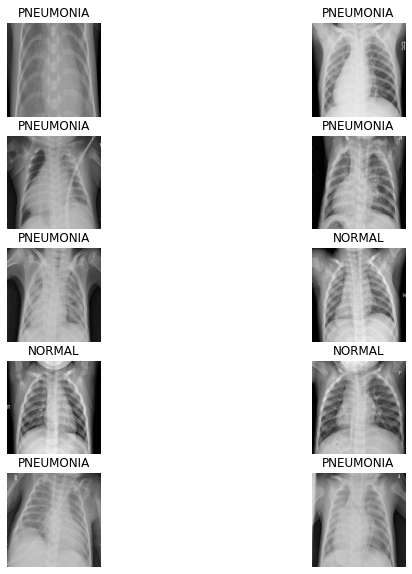

In [115]:
image_batch, label_batch = next(iter(train_ds))
print(image_batch[0].shape)
show_batch(image_batch.numpy(), label_batch.numpy())

In [116]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
418/418 [==============================] - 73s 148ms/step - loss: 0.5254 - accuracy: 0.7297 - precision: 0.9118 - recall: 0.7001 - val_loss: 0.9174 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 61s 147ms/step - loss: 0.3091 - accuracy: 0.8796 - precision: 0.9680 - recall: 0.8684 - val_loss: 0.1776 - val_accuracy: 0.9452 - val_precision: 0.9837 - val_recall: 0.9413
Epoch 3/10
418/418 [==============================] - 61s 147ms/step - loss: 0.2660 - accuracy: 0.8890 - precision: 0.9632 - recall: 0.8830 - val_loss: 0.1290 - val_accuracy: 0.9538 - val_precision: 0.9864 - val_recall: 0.9503
Epoch 4/10
418/418 [==============================] - 62s 148ms/step - loss: 0.2366 - accuracy: 0.9085 - precision: 0.9657 - recall: 0.9092 - val_loss: 0.1414 - val_accuracy: 0.9462 - val_precision: 0.9876 - val_recall: 0.9385
Epoch 5/10
418/418 [==============================] - 63s 150ms/step - loss: 0.2124 - accura

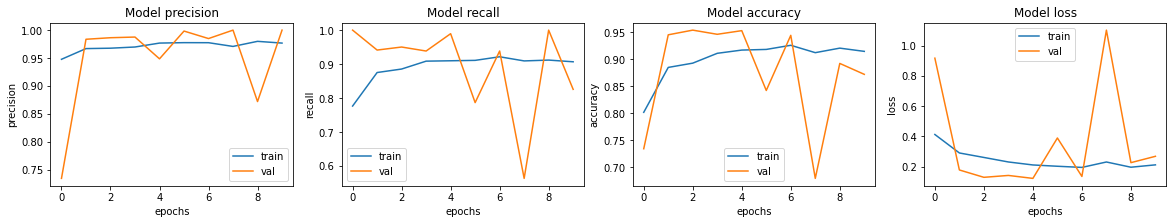

In [117]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [118]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 6s 91ms/step - loss: 0.3652 - accuracy: 0.8301 - precision: 0.8568 - recall: 0.8744
Loss: 0.3652152717113495,
Accuracy: 0.8301281929016113,
Precision: 0.856783926486969,
Recall: 0.8743589520454407


In [119]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

EPOCHS = 25
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
418/418 [==============================] - 73s 147ms/step - loss: 0.5603 - accuracy: 0.7007 - precision: 0.9014 - recall: 0.6704 - val_loss: 1.4290 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
418/418 [==============================] - 60s 145ms/step - loss: 0.3121 - accuracy: 0.8648 - precision: 0.9617 - recall: 0.8541 - val_loss: 0.1839 - val_accuracy: 0.9327 - val_precision: 0.9234 - val_recall: 0.9909
Epoch 3/25
418/418 [==============================] - 61s 146ms/step - loss: 0.2604 - accuracy: 0.8847 - precision: 0.9677 - recall: 0.8751 - val_loss: 0.1255 - val_accuracy: 0.9558 - val_precision: 0.9852 - val_recall: 0.9543
Epoch 4/25
418/418 [==============================] - 62s 148ms/step - loss: 0.2326 - accuracy: 0.9116 - precision: 0.9756 - recall: 0.9043 - val_loss: 0.5527 - val_accuracy: 0.7798 - val_precision: 1.0000 - val_recall: 0.7003
Epoch 5/25
418/418 [==============================] - 63s 151ms/step - loss: 0.2211 - accura

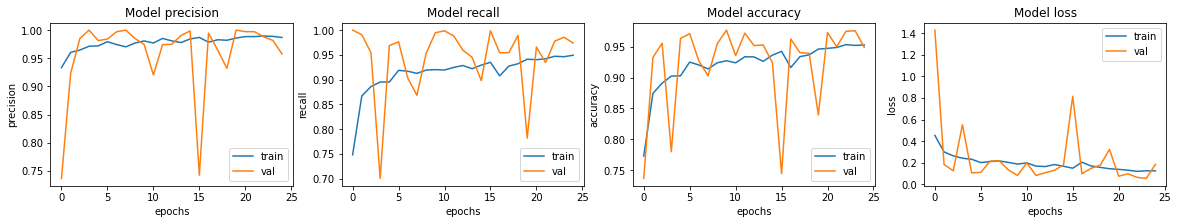

In [120]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [121]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 6s 92ms/step - loss: 1.1280 - accuracy: 0.7628 - precision: 0.7283 - recall: 0.9897
Loss: 1.1280345916748047,
Accuracy: 0.7628205418586731,
Precision: 0.7283018827438354,
Recall: 0.9897435903549194


accuracy는 낮지만 recall이 매우 높군요  
암환자를 멀쩡하다고 분류하는 경우는 매우 적다고 볼 수 있습니다  
오버피팅을 고려해서 Epoch를 줄여서 다시 테스트해보겠습니다

In [123]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

EPOCHS = 20
BATCH_SIZE = 12
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
348/348 [==============================] - 65s 155ms/step - loss: 0.5744 - accuracy: 0.7120 - precision: 0.9146 - recall: 0.6710 - val_loss: 0.6544 - val_accuracy: 0.7368 - val_precision: 0.7368 - val_recall: 1.0000
Epoch 2/20
348/348 [==============================] - 53s 151ms/step - loss: 0.3196 - accuracy: 0.8686 - precision: 0.9561 - recall: 0.8635 - val_loss: 1.1480 - val_accuracy: 0.7414 - val_precision: 0.7414 - val_recall: 1.0000
Epoch 3/20
348/348 [==============================] - 53s 151ms/step - loss: 0.2397 - accuracy: 0.9101 - precision: 0.9753 - recall: 0.9000 - val_loss: 0.3139 - val_accuracy: 0.8460 - val_precision: 0.8280 - val_recall: 1.0000
Epoch 4/20
348/348 [==============================] - 52s 151ms/step - loss: 0.2838 - accuracy: 0.8779 - precision: 0.9573 - recall: 0.8762 - val_loss: 0.2196 - val_accuracy: 0.9000 - val_precision: 0.8809 - val_recall: 0.9984
Epoch 5/20
348/348 [==============================] - 54s 157ms/step - loss: 0.2488 - accura

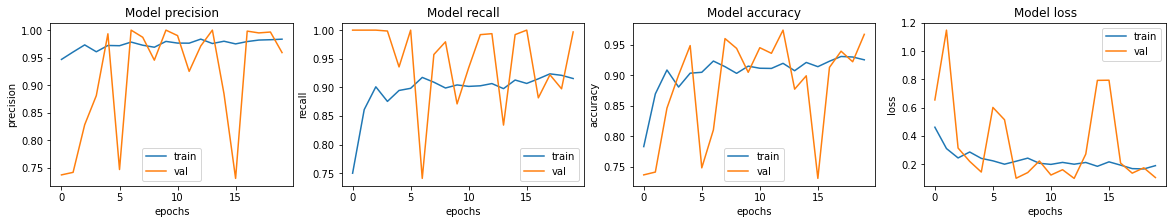

In [124]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [125]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 6s 92ms/step - loss: 0.9353 - accuracy: 0.7099 - precision: 0.6843 - recall: 0.9949
Loss: 0.9352616667747498,
Accuracy: 0.7099359035491943,
Precision: 0.684303343296051,
Recall: 0.9948717951774597


하지만 val_accuracy에 비해 테스트 결과가 너무 처참하게 나오는군요...  
recall은 여전히 높지만 정확도가 기대 이하입니다 아쉽습니다  
  
# 결론  
batch_nomalization, dropout등을 제거했을 때는 별다른 성능개선이 없었음,  
argumentation 으로 사진들을 좌우반전해줬을때 유의미한 성능개선 확인  
Epoch를 10회로 줄였을때 높은 정확도를 얻었지만 Recall 수치가 높아 의료용으로는 부적절  
최종 정확도 84%